# What factors influence Airbnb price?

1. reverse geocode to obtain district from lat/long data -> call Geemente API to obtain geometry of each district and then spatially jjoin airbnb locations to these geometries
2. as


Notes to self: 

- transform chi square to normal and apply anova, square root
- remove outliers? not sure

In [ ]:
!pip install geopandas
!pip install geopy

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

In [43]:
df = pd.read_csv('listings\listings.csv', header = 0)
df.head(5)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2818,https://www.airbnb.com/rooms/2818,20250302144653,2025-03-03,city scrape,Quiet Garden View Room & Super Fast Wi-Fi,Quiet Garden View Room & Super Fast Wi-Fi,"Indische Buurt (""Indies Neighborhood"") is a ne...",https://a0.muscache.com/pictures/10272854/8dcc...,3159,...,4.98,4.73,4.80,0363 5F3A 5684 6750 D14D,f,1,0,1,0,2.05
1,27886,https://www.airbnb.com/rooms/27886,20250302144653,2025-03-03,previous scrape,"Romantic, stylish B&B houseboat in canal district",Stylish and romantic houseboat on fantastic hi...,"Central, quiet, safe, clean and beautiful.",https://a0.muscache.com/pictures/02c2da9d-660e...,97647,...,4.92,4.89,4.77,0363 974D 4986 7411 88D8,f,1,0,1,0,1.84
2,28871,https://www.airbnb.com/rooms/28871,20250302144653,2025-03-03,city scrape,Comfortable double room,Basic bedroom in the center of Amsterdam.,"Flower market , Leidseplein , Rembrantsplein",https://a0.muscache.com/pictures/160889/362340...,124245,...,4.94,4.94,4.83,0363 607B EA74 0BD8 2F6F,f,2,0,2,0,3.83
3,29051,https://www.airbnb.com/rooms/29051,20250302144653,2025-03-03,city scrape,Comfortable single room,This room can also be rented as a single or a ...,the street is quite lively especially on weeke...,https://a0.muscache.com/pictures/162009/bd6be2...,124245,...,4.92,4.87,4.79,0363 607B EA74 0BD8 2F6F,f,2,0,2,0,4.67
4,44391,https://www.airbnb.com/rooms/44391,20250302144653,2025-03-03,previous scrape,Quiet 2-bedroom Amsterdam city centre apartment,Guests greatly appreciate the unique location ...,The appartment is located in the city centre. ...,https://a0.muscache.com/pictures/97741545/3900...,194779,...,4.90,4.68,4.50,0363 E76E F06A C1DD 172C,f,1,1,0,0,0.24


We will try to predict the price of the listing. Let's look at the formatting of the price column.

In [44]:
df.price

0         $66.00
1            NaN
2         $75.00
3         $59.00
4            NaN
          ...   
10070    $355.00
10071    $144.00
10072    $138.00
10073    $126.00
10074    $214.00
Name: price, Length: 10075, dtype: object

There are some missing values, which we will remove. For the rest, we will remove the dollar sign and convert the price to a float. 

In [45]:
df = df.dropna(subset=['price']) 

def clean_price(price):
    
    price = price.replace("$", "")
    price = price.replace(",", "")
    
    price = float(price)
    return price

df.price = df.price.apply(clean_price)

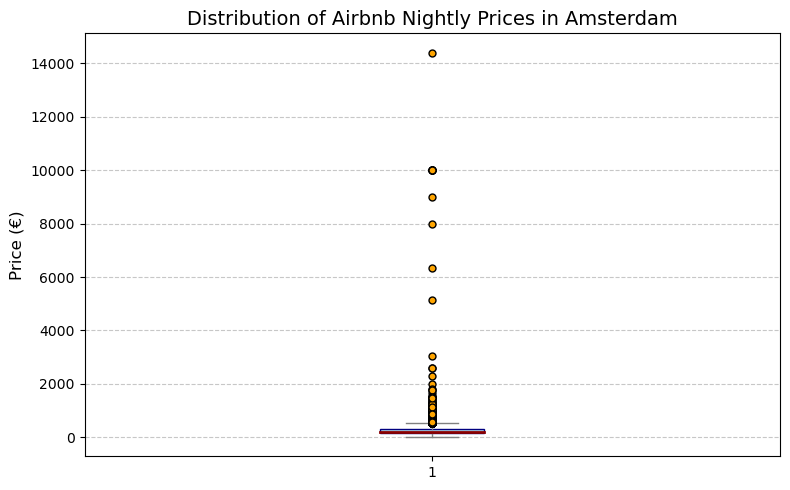

count     5911.000000
mean       265.115716
std        422.193489
min         10.000000
25%        145.000000
50%        209.000000
75%        300.000000
max      14404.000000
Name: price, dtype: float64
Median price is 209.0 euros.


In [240]:
# Create a figure
plt.figure(figsize=(8, 5))

# Draw the boxplot
plt.boxplot(df.price, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='navy'),
            medianprops=dict(color='darkred', linewidth=2),
            whiskerprops=dict(color='gray'),
            capprops=dict(color='gray'),
            flierprops=dict(marker='o', markerfacecolor='orange', markersize=5, linestyle='none'))

# Add title and labels
plt.title('Distribution of Airbnb Nightly Prices in Amsterdam', fontsize=14)
plt.ylabel('Price (€)', fontsize=12)

# Show grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

# Summary statistics
print(df.price.describe())
print(f"Median price is {df.price.median()} euros.")

The boxplot shows that there are definitely outliers, with some pricecs being as high as 14 000 euros per night! However, we can not remove these measurements as they are likely not an error in recording, but rather a legitmate price for a very luxurious Airbnb.  

The prices summary shows that the mean price is around 265 euros, while the median is 209 euros. The median is higher than the mean, indicating that the prices follow a left skewed distribution, with lower values being more likely. The plot below confirms this idea. It shows a histogram of the prices smaller than 2000 euros, where we cap the prices so that we can make a sensible plot. 

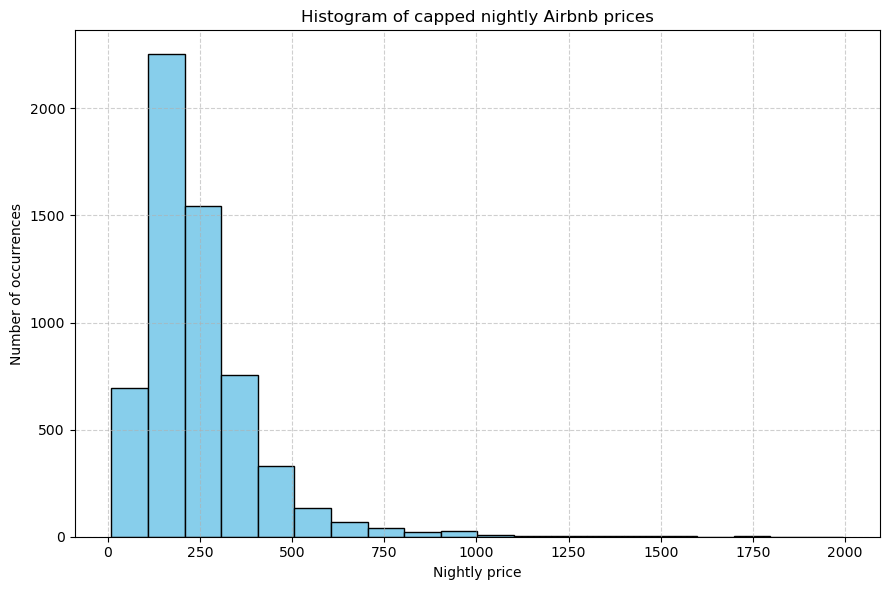

In [288]:
plt.figure(figsize=(9, 6))
plt.hist(df.price[df.price<2000], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of capped nightly Airbnb prices')
plt.xlabel("Nightly price")
plt.ylabel("Number of occurrences")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [46]:
df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,5.911000e+03,5.911000e+03,5.911000e+03,5905.000000,5905.000000,0.0,5911.000000,5911.000000,5911.000000,5910.000000,...,5180.000000,5181.000000,5181.000000,5181.000000,5181.000000,5911.000000,5911.000000,5911.000000,5911.000000,5181.000000
mean,5.834334e+17,2.025030e+13,1.425754e+08,4.787976,8.106520,NaN,52.366880,4.889372,2.962105,1.242893,...,4.785077,4.889647,4.902563,4.817470,4.648120,2.128912,1.278464,0.754187,0.040264,1.316427
std,5.328051e+17,1.871252e+00,1.781636e+08,41.448323,98.113793,NaN,0.017351,0.035339,1.413825,0.537016,...,0.299169,0.209602,0.204770,0.242314,0.315309,3.626369,2.659200,1.997707,0.547941,2.618876
min,2.818000e+03,2.025030e+13,3.159000e+03,1.000000,1.000000,NaN,52.291220,4.755870,1.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.829221e+07,2.025030e+13,1.376450e+07,1.000000,1.000000,NaN,52.355868,4.866425,2.000000,1.000000,...,4.700000,4.860000,4.880000,4.730000,4.510000,1.000000,1.000000,0.000000,0.000000,0.310000
50%,7.101615e+17,2.025030e+13,5.233236e+07,1.000000,1.000000,NaN,52.366040,4.887570,2.000000,1.000000,...,4.880000,4.960000,4.980000,4.890000,4.700000,1.000000,1.000000,0.000000,0.000000,0.550000
75%,1.096901e+18,2.025030e+13,2.213747e+08,2.000000,3.000000,NaN,52.376667,4.906885,4.000000,1.500000,...,5.000000,5.000000,5.000000,5.000000,4.830000,1.000000,1.000000,1.000000,0.000000,1.430000
max,1.367367e+18,2.025030e+13,6.815058e+08,1133.000000,5358.000000,NaN,52.425120,5.026430,16.000000,17.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,36.000000,31.000000,17.000000,9.000000,101.590000


Seeing as the neighbourhood_group_cleansed column only has missing values, we remove it. 

In [47]:
df=df.drop(['neighbourhood_group_cleansed', 'calendar_updated'], axis=1, errors = 'ignore')

Let's see the rest of the columns now.

In [48]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms',
       'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_3

We will remove some columns which are irrelevant to the EDA, such as listing name, scraping info etc. 

In [49]:
irrelevant_cols = [ 'name','scrape_id','scrape_id', 'source', 'picture_url', 'last_scraped', 
                    'neighbourhood_cleansed','host_name', 'host_url', 'host_thumbnail_url', 'host_picture_url',
                   'calendar_last_scraped', 'listing_url']
df=df.drop(irrelevant_cols,axis=1, errors = 'ignore')

## Handling missing data

As price is what we are trying to predict, we will drop rows where the price is missing. 

In [50]:
print(df.isna().sum())
print(df.isna().sum().unique())

id                                                 0
description                                      227
neighborhood_overview                           2908
host_id                                            0
host_since                                         6
                                                ... 
calculated_host_listings_count                     0
calculated_host_listings_count_entire_homes        0
calculated_host_listings_count_private_rooms       0
calculated_host_listings_count_shared_rooms        0
reviews_per_month                                730
Length: 65, dtype: int64
[   0  227 2908    6  738 2760  966  386   97 4372    1    7   16  133
  730  731   89]


We won't use string values such as the description of the listing, host, or the neighbourhood as a predictor. However, their length might be a useful predictor. For example, if a host has given a long description of themselves, the neighbourhood, or the property, the potential user might feel more secure making a booking with this host. 

In [51]:
df.host_about = df.host_about.apply(lambda x: len(str(x)))
df.neighborhood_overview =df.neighborhood_overview.apply(lambda x: len(str(x)))
df.description = df.description.apply(lambda x: len(str(x)))

Next we check which columns have a lot of missing values.

In [52]:
columns = df.columns
columns[df.isna().sum()> 1000]

Index(['host_neighbourhood', 'neighbourhood'], dtype='object')

The host_neighbourhood column has a lot of missing data - it seems hosts are reluctant to input where they live. We can not use the ANOVA model on missing data, and there is no way to determine the host's neighbourhood through proxy data. We will remove the column. 

In [53]:
df = df.drop('host_neighbourhood', axis = 1, errors = 'ignore')

Neighbourhood is self-reported, and as we will see later on, not accurate. We will replace this column later by a correct neighbourhood of the listing, obtained from the latitude and longitude data of the listing. Let's do this now. 

### The neighbourhood column


In [54]:
df['neighbourhood'].unique()

array(['Amsterdam, North Holland, Netherlands', nan,
       'Amsterdam, NH, Netherlands',
       'Amsterdam, Noord-Holland, Netherlands',
       'Watergraafsmeer, North Holland, Netherlands',
       'Zeeburg, North Holland, Netherlands',
       'Amsterdam-Zuidoost, North Holland, Netherlands',
       'Amsterdam, Haarlemmerbuurt, Netherlands',
       'Amsterdam, Netherlands', 'Amsterdam, Noord Holland, Netherlands',
       'Amsterdam, Holland, Netherlands',
       'Amsterdam Zuid-Oost, Noord-Holland, Netherlands',
       'Amsterdam, Emmy andriessestraat, Netherlands',
       'Amsterdam, AH, Netherlands', 'Amsterdam, GA, Netherlands',
       'Amsterdam, GD, Netherlands', 'Amsterdam, Amstel, Netherlands',
       'Amsterdam , 2 de Egelantiersdwarsstraat 13 III, Netherlands',
       'Amsterdam, Overtoom, Netherlands',
       'Amsterdam-Zuidoost, Noord-Holland, Netherlands',
       'Amsterdam , Noord-Holland, Netherlands',
       'Diemen, Noord-Holland, Netherlands', 'Amsterdam, NM, Netherla

We have to clean up this column. First, we remove the Netherlands, Noord-Holland and Amsterdam from each of these names. This is extra information we do not need, as we know we are studying airbnb's in Amsterdam, Noord-Holland, the Netherlands. 

In [55]:
df['neighbourhood'] = df['neighbourhood'].map(lambda x: str(x).lower())
df['neighbourhood'] = df['neighbourhood'].map(lambda x: str(x).replace('amsterdam', ''))
df['neighbourhood'] = df['neighbourhood'].map(lambda x: str(x).replace('north holland', ''))
df['neighbourhood'] = df['neighbourhood'].map(lambda x: str(x).replace('noord-holland', ''))
df['neighbourhood'] = df['neighbourhood'].map(lambda x: str(x).replace('noord holland', ''))
df['neighbourhood'] = df['neighbourhood'].map(lambda x: str(x).replace('netherlands', ''))

In [56]:
df['neighbourhood'] = df['neighbourhood'].map(lambda x: str(x).replace(', ', ''))

In [57]:
df.neighbourhood.unique()

array(['', 'nan', 'nh', 'watergraafsmeer', 'zeeburg', '-zuidoost',
       'haarlemmerbuurt', 'holland', ' zuid-oost', 'emmy andriessestraat',
       'ah', 'ga', 'gd', 'amstel', ' 2 de egelantiersdwarsstraat 13 iii',
       'overtoom', ' ', 'diemen', 'nm', 'badhoevedorp', '-centrum',
       'nord holland', 'oostzaan', 'ouder-amstel', 'lijnden', '[no name]',
       'duivendrecht', ' the '], dtype=object)

It seems like we will not be able to get the correct neighbourhood names from these user-input values. We will try something else: we will determine the neighbourhood from the latitude and longitude data. We will use reverse geocoding to do this.


In [58]:
df = df.drop('neighbourhood', axis = 1, errors = 'ignore')

### Reverse geocoding to determine the neighbourhood
We start by importing the relevant library. We then show an example of how it works: we input a latitude, longitude pair, and we get an address in return.

In [59]:
from geopy.geocoders import Nominatim

In [60]:
lat_long_ex = [df.iloc[0]['latitude'], df.iloc[0]['longitude'] ]

geoLoc = Nominatim(user_agent= 'GetLoc')

locname = geoLoc.reverse(lat_long_ex)

print(f"Latitude and longitude are {lat_long_ex}, and the (approximate) address is {locname.address}")

Latitude and longitude are [52.36435, 4.94358], and the (approximate) address is Soembawastraat, Indische Buurt, Oost, Amsterdam, Noord-Holland, Nederland, 1095 XB, Nederland


In [61]:
geoLoc = Nominatim(user_agent= 'GetLoc')

def get_address(latitude, longitude):
    
    locname = geoLoc.reverse([latitude, longitude])
    
    return locname.address

In [62]:
try: 
    df.apply(lambda x : geoLoc.reverse([x.latitude, x.longitude]).address, axis = 1)
except:
    print("time out error, you are making too many calls to the API.")

time out error, you are making too many calls to the API.


Our dataset is too large for us to use geopy. We have 10 000 rows in the dataset, meaning we make 10 000 calls to the API in one instance. We could try to sparse out the calls by putting in a time buffer inbetween every (for example) 20 calls, but this would take too long. Instead, we will download the shape data of the 9 districts of Amsterdam, and spatially join (match) each Airbnb location to the district it is contained in. 

In [63]:
import requests
import time
url = "https://api.data.amsterdam.nl/v1/gebieden/stadsdelen"

In [243]:
response = requests.get(url).json()
list_districts = response['_embedded']['stadsdelen']
print(list_districts[0])

{'_links': {'schema': 'https://schemas.data.amsterdam.nl/datasets/gebieden/dataset#stadsdelen', 'self': {'href': 'https://api.data.amsterdam.nl/v1/gebieden/stadsdelen/03630000000016/?volgnummer=4', 'title': 'Zuidoost', 'identificatie': '03630000000016', 'volgnummer': 4}, 'ligtInGemeente': {'href': 'https://api.data.amsterdam.nl/v1/brk2/gemeentes/0363.3/', 'title': '0363.3', 'identificatie': '0363.3'}}, 'identificatie': '03630000000016', 'volgnummer': 4, 'registratiedatum': '2024-01-25T20:36:51', 'naam': 'Zuidoost', 'code': 'T', 'beginGeldigheid': '2023-10-25T00:00:00', 'eindGeldigheid': None, 'documentdatum': '2023-10-12', 'documentnummer': 'VN2023-019835', 'ligtInGemeenteId': '0363', 'geometrie': {'type': 'Polygon', 'coordinates': [[[129273.237, 480094.372], [129275.729, 480086.663], [129279.939, 480071.565], [129282.86, 480061.364], [129285.781, 480051.163], [129288.702, 480040.961], [129260.356, 480027.965], [129232.009, 480014.969], [129220.792, 480012.121], [129209.575, 480009.273

Note that the coordinates look unfamiliar: one point in Zuidoost is, for example, of value [129157.697, 479968.202]. This is not the standard coordinate system we use (the so called WGS84). Instead, it is a projection used by the Dutch municipality that is based on the location of the Onze Lieve Vrouwetoren in Amersfoort. For more details, see: https://nl.wikipedia.org/wiki/Rijksdriehoeksco%C3%B6rdinaten# 

We therefore have to first convert the cooridnates to the WGS84 system. For this, I make use of the publicly available code which can be found here: https://github.com/thomasvnl/rd-to-wgs84/blob/master/conversions.py

In [66]:
import shapely
from conversions import RDWGS84Converter
converter = RDWGS84Converter()

In [67]:
districts = []  #here we will store district names, and their geometries converted to standard coordinates 

for i in range(len(list_districts)):
    
    district_info = {}
    
    district_name = list_districts[i]['naam']
    
    print(district_name)

    district_geom = list_districts[i]['geometrie'].copy()
    
    coord_converted =  [[converter.from_rd(x[0],x[1])[1],converter.from_rd(x[0],x[1])[0]]  for x in list_districts[i]['geometrie']['coordinates'][0].copy() ]
    
    district_geom = shapely.Polygon(coord_converted)
    
    district_info["neighbourhood"] = district_name
    district_info["geometry"] = district_geom
    
    districts.append(district_info)

Zuidoost
Centrum
Noord
Westpoort
West
Nieuw-West
Zuid
Oost
Weesp


Now we have the district shape data, we can make a geodata frame from both this data, and the Airbnb data. When this is done, we do a spatial join between these two geodata sets, in order to attach to each listing its district. 

In [68]:
import geopandas as gpd

In [69]:
districts_geodataset = gpd.GeoDataFrame(
    pd.DataFrame(districts), geometry = 'geometry', crs="EPSG:4326")

In [70]:
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs = 'EPSG:4326')
if 'Position' not in df.columns:
    df = df.rename_geometry('Position')

In [71]:
df=df.sjoin(districts_geodataset, how = 'left', predicate = 'within')

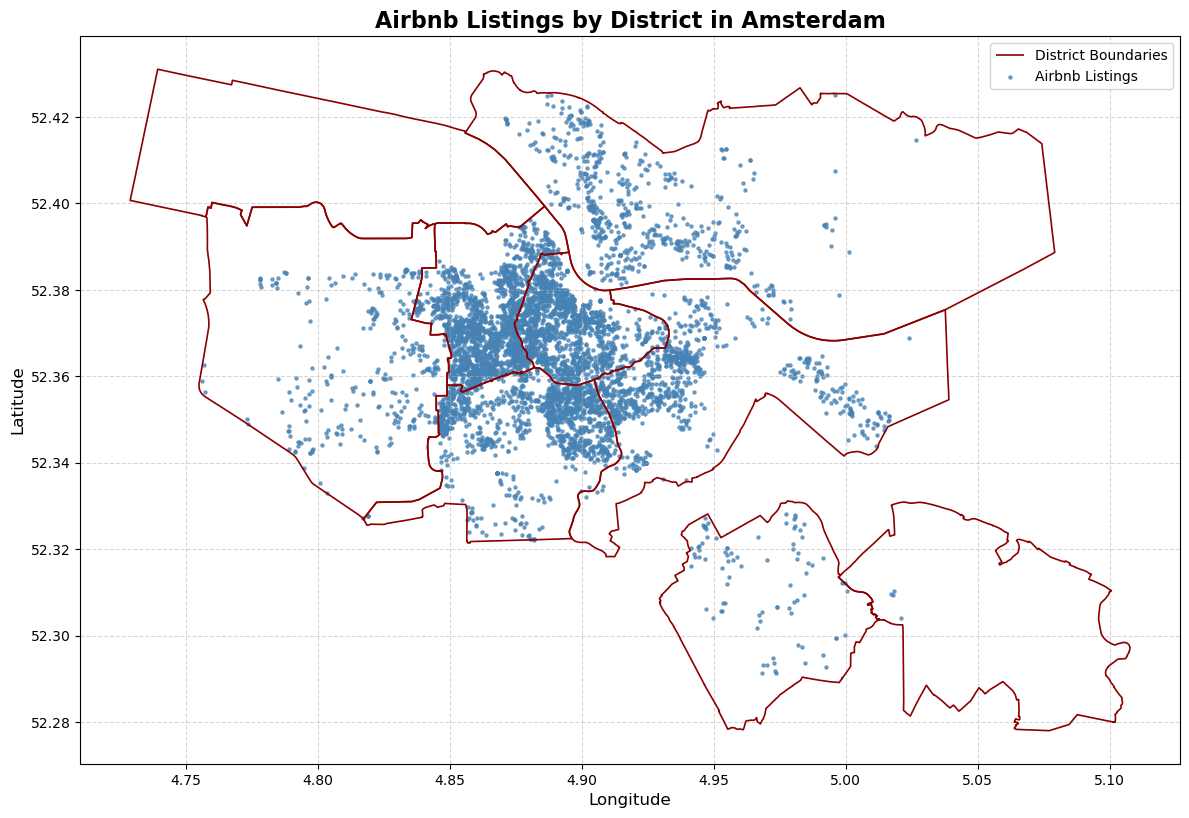

In [72]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 12))

districts_geodataset.boundary.plot(ax=ax, linewidth=1.2, edgecolor='darkred', label='District Boundaries')

df.plot(ax=ax, markersize=5, color='steelblue', alpha=0.7, label='Airbnb Listings')

ax.set_title('Airbnb Listings by District in Amsterdam', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

ax.legend(loc='upper right')

ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()

plt.show()

### Back to other missing data

Let's see what other columns are missing data. 

In [73]:
print(f"There are {df.shape[0]} rows in the dataset, in total.")
columns = df.columns

for col in columns:
    if df[col].isna().sum() != 0:
        print(f"Empty rows: {df[col].isna().sum()}, Column: {col}")

There are 5911 rows in the dataset, in total.
Empty rows: 6, Column: host_since
Empty rows: 738, Column: host_location
Empty rows: 966, Column: host_response_time
Empty rows: 966, Column: host_response_rate
Empty rows: 386, Column: host_acceptance_rate
Empty rows: 97, Column: host_is_superhost
Empty rows: 6, Column: host_listings_count
Empty rows: 6, Column: host_total_listings_count
Empty rows: 6, Column: host_has_profile_pic
Empty rows: 6, Column: host_identity_verified
Empty rows: 1, Column: bathrooms
Empty rows: 7, Column: bathrooms_text
Empty rows: 6, Column: bedrooms
Empty rows: 16, Column: beds
Empty rows: 133, Column: has_availability
Empty rows: 730, Column: first_review
Empty rows: 730, Column: last_review
Empty rows: 730, Column: review_scores_rating
Empty rows: 730, Column: review_scores_accuracy
Empty rows: 731, Column: review_scores_cleanliness
Empty rows: 730, Column: review_scores_checkin
Empty rows: 730, Column: review_scores_communication
Empty rows: 730, Column: revi

Notice this: first_review, last_review, review_scores_* and reviews_per_month all have 730 (or 731) missing entries. We can only assume that these overlap perfectly: a host who has never had a review will never have had a first or a last review or any reviews per month. Let's check this assumption.

In [74]:
print(f"There are { len(df[df['number_of_reviews']==0])} rows in the dataset with no reviews.")

rows_missing_nr_reviews = [row  for row in range(len(df)) if df.iloc[row]['number_of_reviews']==0]

#checking that these rows are exactly the ones with missing values for the rest of the columns involving reviews. 
cols_730_miss_bool = [df[col].isna().sum() in [730,731] for col in columns]

cols_730_miss = columns[cols_730_miss_bool]

for col in cols_730_miss: 
    if (df.iloc[rows_missing_nr_reviews]['number_of_reviews'].any()!=0):
        print('Your hypothesis is not true. ')

There are 730 rows in the dataset with no reviews.


<!-- We expect reviews to be indicative of price: the higher the reviews, the more likely the price will be high too. Hence, we won't drop these rows: to do so could inttroduce a bias: maybe people aren't leaving reviews to these Airbnbs because they are not booking them because their price is too high! If we remove these rows, we might be removing the high priced Airbnbs, and therefore introduce bias in the model.  -->

We expect we won't include all the "review" predictors into the price model, since they will likelly be highly correlated. Thus, we focus on the main review, a.k.a the review_scores_rating. Indeed, let's see the correlation plots. 



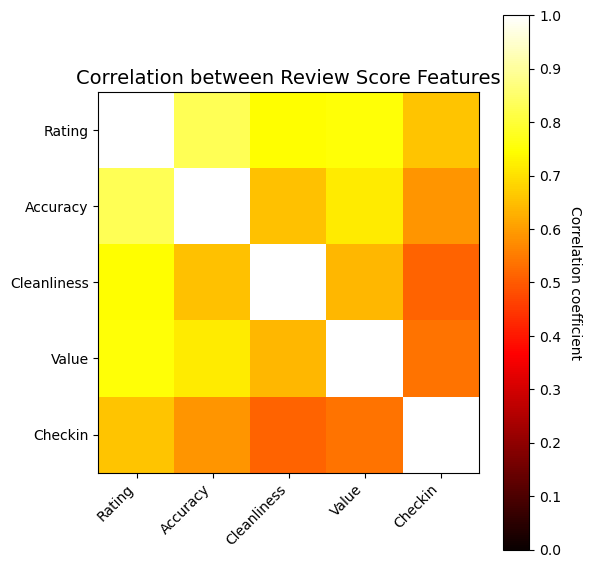

In [75]:
corr = df[["review_scores_rating","review_scores_accuracy", "review_scores_cleanliness", "review_scores_value", "review_scores_checkin"]].corr()


cols = [
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_value",
    "review_scores_checkin"
]

corr = df[cols].corr()

labels = [col.replace("review_scores_", "").capitalize() for col in cols]

plt.figure(figsize=(6, 6))
im = plt.imshow(corr, cmap='hot', vmin=0, vmax=1)

plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(labels)), labels=labels)

cbar = plt.colorbar(im, ticks=np.linspace(0, 1, 11))
cbar.set_label('Correlation coefficient', rotation=270, labelpad=15)

plt.title("Correlation between Review Score Features", fontsize=14)
plt.tight_layout()
plt.show()


What could be the case is that the Airbnb's with missing reviews weren't deserving of a high rating (were dirty, at a poor location, etc.) and the customers didn't want to give a low review score, so they left it blank. This is so called MNAR (Missing not at random) data, and it's highly problematic because it can not be removed (this would introduce bias) or approximated through an observed variable (as it depends on itself, rather than another variable).

What could also be the case is that the data is MAR (missing at random). This means that there is a proxy variable which we could use to predict the missing reviews. We will explore this possibility.

Lastly, it  is possible that the data is MCAR (missing completely at random) and can be disgarded. For example, the listing could be so new that there simply haven't been any bookings yet. We do not have access to the date when the listing was created in the dataset. Instead, to check if there has been a booking yet, we  will check if the acceptance rate is missing. If there has not been a booking yet, the acceptance rate ((nr of accepts)/(number of requests)) is missing, as the number of requests is 0. Note: since the acceptance rate is tied to the host and NOT the listing, we can only do this with hosts that have only one listing. 

In [76]:
rows_missing_reviews_single_listing = [row for row in rows_missing_nr_reviews if
                                       df.iloc[row]["host_listings_count"] ==1]
unbooked_ratio = np.mean(df['host_acceptance_rate'].iloc[rows_missing_reviews_single_listing].isna())
print(f"{np.round(100*unbooked_ratio,2)}% of the listings with missing reviews have not been booked before.")

31.38% of the listings with missing reviews have not been booked before.


That's not a high percentage, and it means that we are likely not dealing with MCAR data. Let's check now if the data is MAR. 
Let's have a look at possible proxy predictors.

In [77]:
columns[df.isna().sum() == 0]

Index(['id', 'description', 'neighborhood_overview', 'host_id', 'host_about',
       'host_verifications', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'availability_eoy', 'number_of_reviews_ly', 'estimated_occupancy_l365d',
       'estimated_revenue_l365d', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'Position',
       'index_right', 'neighbourhood'],
      dtype='object')

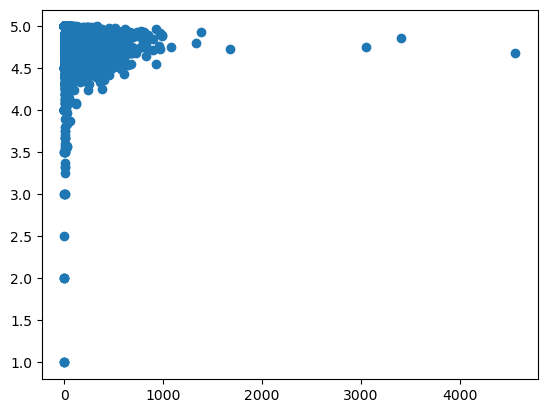

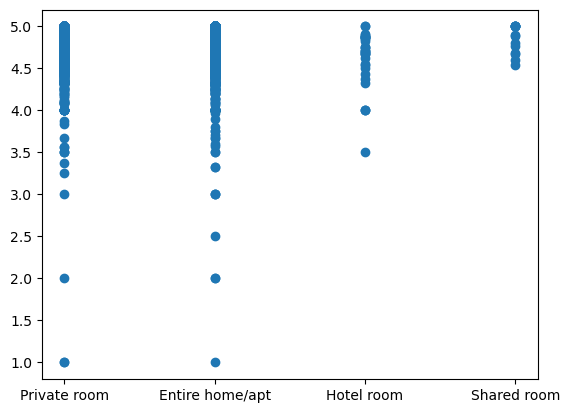

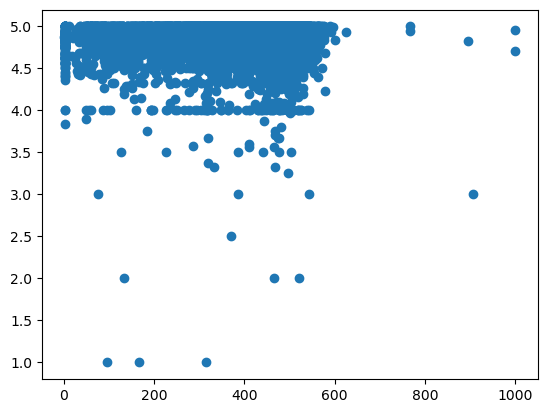

In [78]:
plt.figure()
plt.scatter(df['number_of_reviews'], df["review_scores_rating"])

plt.figure()
plt.scatter(df["room_type"], df["review_scores_rating"])

plt.figure()
plt.scatter(df["description"], df["review_scores_rating"])

Seeing as there is no clear relationship with any other observed predictors, we can not estimate the review score this way. Let us look at a histogram of the review scores.

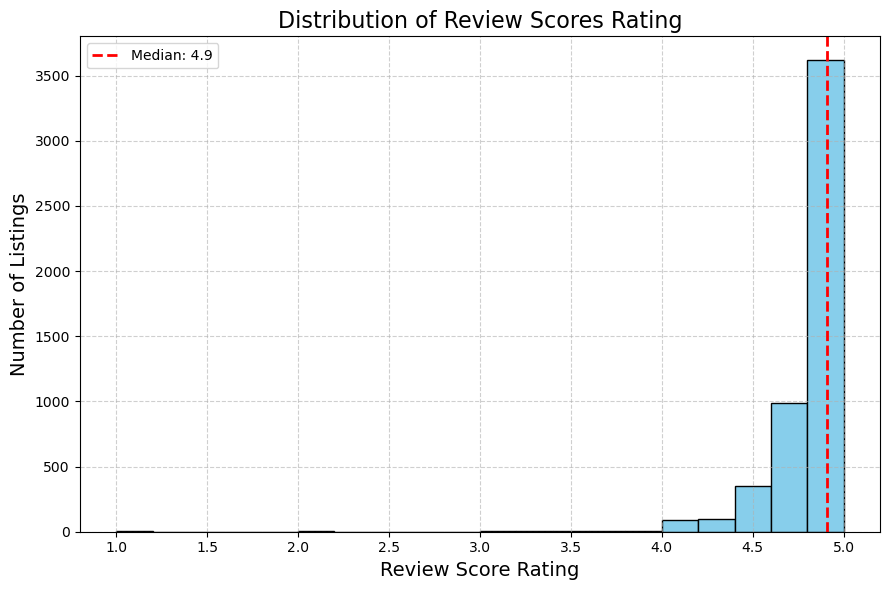

In [79]:
ratings = df['review_scores_rating'].dropna()
median_rating = ratings.median()

plt.figure(figsize=(9, 6))
plt.hist(ratings, bins=20, color='skyblue', edgecolor='black')
plt.axvline(median_rating, color='red', linestyle='--', linewidth=2, label=f'Median: {median_rating:.1f}')
plt.title('Distribution of Review Scores Rating', fontsize=16)
plt.xlabel('Review Score Rating', fontsize=14)
plt.ylabel('Number of Listings', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Unfortunately, since we are probably dealing with MNAR data, we can not just imput the median rating. We need to do something more advanced. 


In [109]:
df['has_review'] = df.review_scores_rating.apply(lambda x: 1 - int(np.isnan(x) ))

## Which factors influence the price? 

The first idea we have is to apply ANOVA to determine whether factors such as neighbourhood influence the listing's price. However, ANOVA has 3 assumptions: 

1. Normality of response variable withing each group
2. Homoscedascity of groups
3. Independence of observations

Independence should indeed be the case, and homoscedascity migth be too, but we saw that the prices (at least when they are not split according to neighbourhood) do not look like normal observations. Let's see the prices just from the Oost district. 

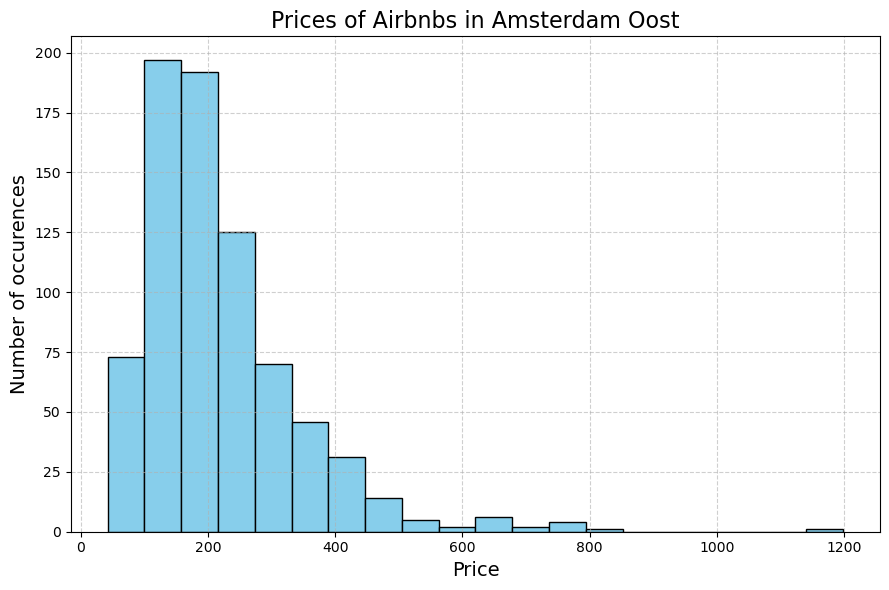

In [284]:
plt.figure(figsize=(9, 6))
plt.hist(nbhds_prices[0], bins=20, color='skyblue', edgecolor='black')
plt.title('Prices of Airbnbs in Amsterdam Oost', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Number of occurences', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

That doesn't look very normal - it looks more like a Chi-squared distribution. Indeed, if we perform the Shapiro-Wilk test for normality, we reject the null hypothesis of normality.

In [285]:
from scipy.stats import shapiro

p_value = shapiro(nbhds_prices[0])[1]
print(f"The p-value is {p_value}, we reject the null hypothesis for normality at level 0.05: {p_value< 0.05}.")

The p-value is 1.2213294078807423e-26, we reject the null hypothesis for normality at level 0.05: True.


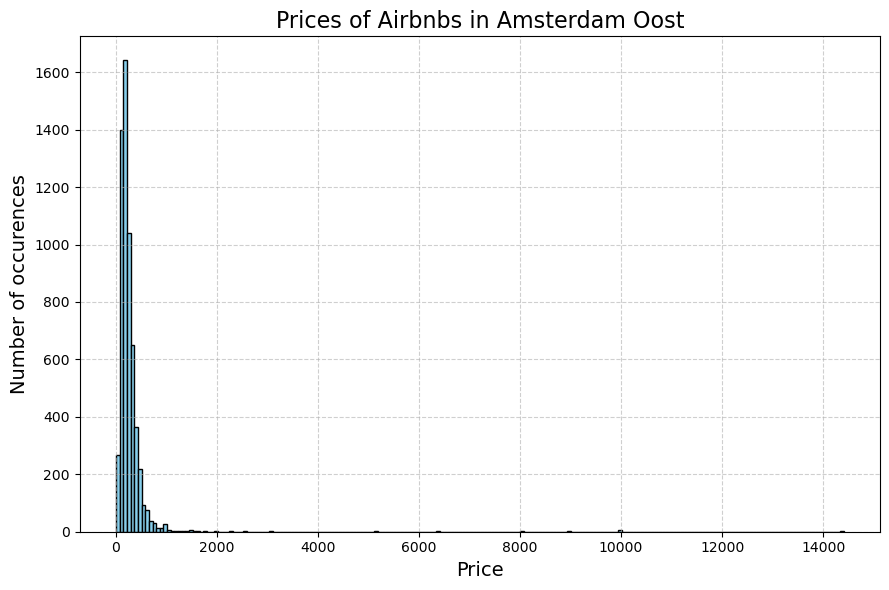

In [292]:
plt.figure(figsize=(9, 6))
plt.hist(df.price, bins=200, color='skyblue', edgecolor='black')
plt.title('Prices of Airbnbs in Amsterdam Oost', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Number of occurences', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()